In [1]:
import os, pickle, sys
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import glob
from prettytable import PrettyTable
from tqdm import tqdm

## Table 1: Spearman ρ of zero-cost proxies on NAS-Bench-201.

In [2]:
t=None
all_ds = {}
all_acc = {}
allc = {}
all_metrics = {}
all_runs = {}
metric_names = ['grad_norm', 'snip', 'grasp', 'fisher', 'synflow', 'jacob_cov']
for fname,rname in [('../results_release/nasbench2/nb2_cf10_seed42_dlrandom_dlinfo1_initwnone_initbnone.p','CIFAR10'),
                    ('../results_release/nasbench2/nb2_cf100_seed42_dlrandom_dlinfo1_initwnone_initbnone.p','CIFAR100'),
                    ('../results_release/nasbench2/nb2_im120_seed42_dlrandom_dlinfo1_initwnone_initbnone.p','ImageNet16-120')]:
    runs=[]
    f = open(fname,'rb')
    while(1):
        try:
            runs.append(pickle.load(f))
        except EOFError:
            break
    f.close()
    print(fname, len(runs))
    
    all_runs[fname]=runs
    all_ds[fname] = {}
    metrics={}
    for k in metric_names:
        metrics[k] = []
    acc = []
    
    if t is None:
        hl=['Dataset']
        hl.extend(metric_names)
        t = PrettyTable(hl)
    
    for r in runs:
        for k,v in r['logmeasures'].items():
            if k in metrics:
                metrics[k].append(v)
        acc.append(r['testacc'])
    
    all_ds[fname]['metrics'] = metrics
    all_ds[fname]['acc'] = acc
        
    res = []
    crs = {}
    for k in hl:
        if k=='Dataset':
            continue
        v = metrics[k]
        cr = abs(stats.spearmanr(acc,v,nan_policy='omit').correlation)
        #print(f'{k} = {cr}')
        res.append(round(cr,3))
        crs[k]=cr
    
    ds = rname
    all_acc[ds]=acc
    allc[ds]=crs
    t.add_row([ds]+res)
    
    all_metrics[ds] = metrics
print(t)

../results_release/nasbench2/nb2_cf10_seed42_dlrandom_dlinfo1_initwnone_initbnone.p 15625
../results_release/nasbench2/nb2_cf100_seed42_dlrandom_dlinfo1_initwnone_initbnone.p 15625
../results_release/nasbench2/nb2_im120_seed42_dlrandom_dlinfo1_initwnone_initbnone.p 15625
+----------------+-----------+-------+-------+--------+---------+-----------+
|    Dataset     | grad_norm |  snip | grasp | fisher | synflow | jacob_cov |
+----------------+-----------+-------+-------+--------+---------+-----------+
|    CIFAR10     |   0.594   | 0.596 | 0.514 |  0.36  |  0.737  |   0.731   |
|    CIFAR100    |   0.637   | 0.637 | 0.547 | 0.385  |  0.763  |   0.704   |
| ImageNet16-120 |   0.578   | 0.578 | 0.549 | 0.327  |  0.751  |   0.701   |
+----------------+-----------+-------+-------+--------+---------+-----------+


### Voting between 3 metrics could improve rank correlation

In [3]:
from tqdm import tqdm
votes = {}
def vote(mets, gt):
    numpos = 0
    for m in mets:
        numpos += 1 if m > 0 else 0
    if numpos >= len(mets)/2:
        sign = +1
    else:
        sign = -1
    return sign*gt

for ds in all_acc.keys():
    num_pts = 15625
    #num_pts = 1000
    tot=0
    right=0
    for i in tqdm(range(num_pts)):
        for j in range(num_pts):
            if i!=j:
                diff = all_acc[ds][i] - all_acc[ds][j]
                if diff == 0:
                    continue
                diffsyn = []
                for m in ['synflow', 'jacob_cov', 'snip']:
                    diffsyn.append(all_metrics[ds][m][i] - all_metrics[ds][m][j])
                same_sign = vote(diffsyn, diff)
                right += 1 if same_sign > 0 else 0
                tot += 1
    votes[ds.lower() if 'CIFAR' in ds else ds] = right/tot
print('votes correlation: ', votes)

100%|██████████| 15625/15625 [08:20<00:00, 31.20it/s]

votes correlation:  {'cifar10': 0.8170822831897641, 'cifar100': 0.8323757385510576, 'ImageNet16-120': 0.8131110314104887}


## Figure 1: Evaluation of different econas proxies on NAS-Bench-201 CIFAR-10

In [4]:
from nas_201_api import NASBench201API as API
api = API('../data/NAS-Bench-201-v1_0-e61699.pth')
api.verbose = False

try to create the NAS-Bench-201 api from ../data/NAS-Bench-201-v1_0-e61699.pth


In [5]:
dallb={}
dallb_10={}
dallb_10f={}
for ds in ['cifar10', 'cifar100','ImageNet16-120']:
    allb = {}
    allb_10 = {}
    allb_10f = {}

    for k in range(0,41):

        b=[]
        b_10 = []
        b_10f = []

        for i in tqdm(range(len(api))):
            info = api.get_more_info(i, 'cifar10-valid' if ds=='cifar10' else ds, iepoch=None, hp='200', is_random=False)
            info_10 = api.get_more_info(i, 'cifar10-valid' if ds=='cifar10' else ds, iepoch=k, hp='200', is_random=False)

            try:
                info_10_fast = api.get_more_info(i, 'cifar10-valid' if ds=='cifar10' else ds, iepoch=k, hp='12', is_random=False)
                testacc_10_fast  = info_10_fast['valid-accuracy' if ds=='cifar10' else 'valtest-accuracy']
            except Exception:
                pass
            
            testacc  = info['test-accuracy']
            testacc_10  = info_10['valid-accuracy' if ds=='cifar10' else 'valtest-accuracy']

            b.append(testacc)
            b_10.append(testacc_10)  
            b_10f.append(testacc_10_fast)

        allb[k] = b
        allb_10[k] = b_10
        allb_10f[k] = b_10f
    dallb[ds]=allb
    dallb_10[ds]=allb_10
    dallb_10f[ds]=allb_10f

100%|██████████| 15625/15625 [00:02<00:00, 5410.74it/s]


In [6]:
dslow = {}
dfast = {}
for ds,allb in dallb.items():
    dslow[ds] = []
    dfast[ds] = []
    t = PrettyTable(['Epoch', 'Normal Training (200 epochs)', 'Fast Training (12 Epochs)'])
    for k,b in allb.items():
        r = [k]
        for v in [dallb_10[ds][k], dallb_10f[ds][k]]:
            cr = abs(stats.spearmanr(b,v,nan_policy='omit').correlation)
            r.append(round(cr,3))
        t.add_row(r)
        dslow[ds].append(r[1])
        dfast[ds].append(r[2])

/home/SERILOCAL/mohamed1.a/anaconda3/envs/snip-torch/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/SERILOCAL/mohamed1.a/anaconda3/envs/snip-torch/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/SERILOCAL/mohamed1.a/anaconda3/envs/snip-torch/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/SERILOCAL/mohamed1.a/anaconda3/envs/snip-torch/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/SERILOCAL/mohamed1.a/anaconda3/envs/snip-torch/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


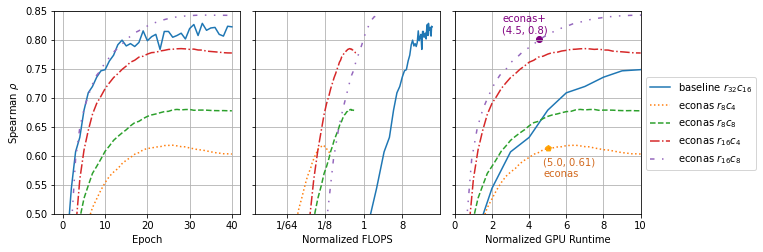

In [7]:
with open('../results_release/nasbench2/nb2_fast_train.p','rb') as f:
    truns = pickle.load(f)
    
per_epochs=[]
for expname in ['nb2_fast_train', 'nb2_fast_train_ch8', 'nb2_fast_train_im16', 'nb2_fast_train_im16_ch8']:

    with open(f'../results_release/nasbench2/{expname}.p','rb') as f:
        truns = pickle.load(f)

    #form array per epoch for fast training
    per_epoch = {}
    for r in truns:
        for i,e in enumerate(r['logmeasures']):
            if i not in per_epoch:
                per_epoch[i] = []
            per_epoch[i].append(e['val_acc'])
    per_epochs.append(per_epoch)
    
ds = 'cifar10'
econas = []
acc = dallb[ds][0]
for exp in per_epochs:
    l = []
    t = PrettyTable(['Epoch', 'Correlation of Proxy Training'])
    for k,b in exp.items():
        r = [k]
        cr = abs(stats.spearmanr(b,acc,nan_policy='omit').correlation)
        r.append(round(cr,3))
        t.add_row(r)
        l.append(cr)
    econas.append(l)

#WE ONLY IMPLEMENT ECONAS FOR CIFAR10

ls = ['solid','dotted','dashed','dashdot',(0, (3, 5, 1, 5, 1, 5))]

ds = 'cifar10'
slow=dslow[ds]
fig, axs = plt.subplots(1,3,figsize=(10.7,3.6), sharey=True)

ax=axs[0]

epx=41

#regular training
x=range(0,epx,1)
ax.plot(x,slow[0:epx], label= 'baseline $r_{32}c_{16}$', linestyle=ls[0])

#econas
x2=range(0,epx,1)
ax.plot(x2,econas[0][0:epx], label='econas $r_8c_4$', linestyle=ls[1])
ax.plot(x2,econas[1][0:epx], label='econas $r_8c_8$', linestyle=ls[2])
ax.plot(x2,econas[2][0:epx], label='econas $r_{16}c_4$', linestyle=ls[3])
ax.plot(x2,econas[3][0:epx], label='econas $r_{16}c_8$', linestyle=ls[4])
ax.grid()
ax.set_ylim(0.5,0.85)
ax.set_xlabel("Epoch")
ax.set_ylabel('Spearman $\\rho$')

#--------------------------------------------------------------------------------
ax=axs[1]

#regular training
x=[ff for ff in range(0,epx)]
ax.plot(x,slow[0:epx], label= 'baseline $r_{32}c_{16}$', linestyle=ls[0])

#econas
d = 230
x2=[ff/d for ff in range(0,epx)]
ax.plot(x2,econas[0][0:epx], label='econas $r_8c_4$', linestyle=ls[1])
d = 59.5
x2=[ff/d for ff in range(0,epx)]
ax.plot(x2,econas[1][0:epx], label='econas $r_8c_8$', linestyle=ls[2])
ax.plot(x2,econas[2][0:epx], label='econas $r_{16}c_4$', linestyle=ls[3])
d = 15.4
x2=[ff/d for ff in range(0,epx)]
ax.plot(x2,econas[3][0:epx], label='econas $r_{16}c_8$', linestyle=ls[4])

ax.grid()
ax.set_ylim(0.5,0.85)
#plt.xlim(0,0.01)
ax.set_xlabel("Normalized FLOPS")
ax.set_xscale('log', basex=2)

from fractions import Fraction
labels = ("1", "1", '1/64', "1/8", "1", "8")
ax.set_xticklabels(labels)

#--------------------------------------------------------------------------------
ax=axs[2]

#regular training
x=[ff for ff in range(0,epx)]
ax.plot(x,slow[0:epx], label= 'baseline $r_{32}c_{16}$', linestyle=ls[0])

#econas
d = 4
x2=[ff/d for ff in range(0,epx)]
ax.plot(x2,econas[0][0:epx], label='econas $r_8c_4$', linestyle=ls[1])
d = 4
x2=[ff/d for ff in range(0,epx)]
ax.plot(x2,econas[1][0:epx], label='econas $r_8c_8$', linestyle=ls[2])
ax.plot(x2,econas[2][0:epx], label='econas $r_{16}c_4$', linestyle=ls[3])
d = 3.3
x2=[ff/d for ff in range(0,epx)]
ax.plot(x2,econas[3][0:epx], label='econas $r_{16}c_8$', linestyle=ls[4])

p=15
ax.scatter(p/d, econas[3][p], marker='o', color='purple')
ax.annotate(f'({round(p/d,1)}, {round(econas[3][p],2)})',(p/d-2, econas[3][p]+0.01), horizontalalignment='left', color='purple')
ax.annotate(f'econas+',(p/d-2, econas[3][p]+0.03), horizontalalignment='left', color='purple')

p=20
ax.scatter(p/4, econas[0][p], marker='p', color='orange')
ax.annotate(f'({round(p/4,1)}, {round(econas[0][p],2)})',(p/d-1.3, econas[0][p]-0.03), horizontalalignment='left', color='chocolate')
ax.annotate(f'econas',(p/d-1.3, econas[0][p]-0.05), horizontalalignment='left', color='chocolate')

ax.grid()
ax.set_ylim(0.5,0.85)
ax.set_xlim(0,10)
ax.set_xlabel("Normalized GPU Runtime")
#ax.set_xscale('log', basex=10)

fig.tight_layout(pad=0.3)
plt.legend(bbox_to_anchor=(1,0.7))
plt.tight_layout()
plt.savefig('econas.pdf')
plt.show()

## Figure 2: Correlation of validation accuracy to final test accuracy during the first 12 epochs training for three datasets on the NAS-Bench-201 search space. Zero-cost and EcoNAS proxies are also labeled for comparison.


cifar10


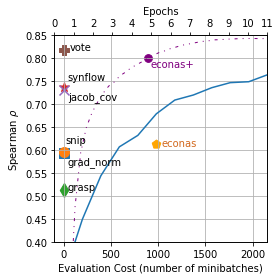

cifar100


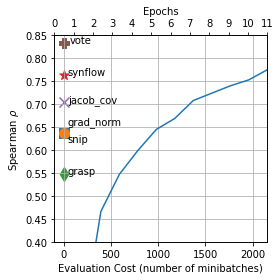

ImageNet16-120


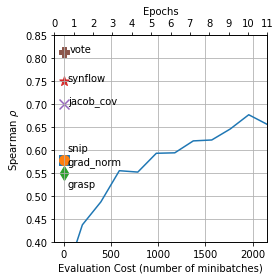

In [8]:
import itertools
sh={
    'cifar10':{
        'jacob_cov':(40,-.02),
        'synflow':(40,.015),
        'snip':(10,.02),
        'grad_norm':(40,-.025),
        'grasp':(40,.0),
        'vote':(60,.0)
    },
    'cifar100':{
        'jacob_cov':(40,.0),
        'synflow':(40,.0),
        'snip':(35,-.02),
        'grad_norm':(35,.02),
        'grasp':(35,.0),
        'vote':(60,.0)
    },
    'ImageNet16-120':{
        'jacob_cov':(40,.0),
        'synflow':(40,.0),
        'snip':(40,.02),
        'grad_norm':(40,-.01),
        'grasp':(40,-.03),
        'vote':(60,.0)
    },
}
markers = {'synflow':'*','jacob_cov':'x','snip':'o','grad_norm':'s','fisher':'+','grasp':'d', 'vote':'P'}
for ds,slow in dslow.items():
    plt.figure(figsize=(4,4))
    x=range(0,196*41,196)
    plt.plot(x,slow)
    for k,v in allc[ds.upper() if 'cifar' in ds else ds].items():
        if v < 0.4:
            continue
        plt.scatter(1,v, marker=markers[k], s=100)
        plt.text(1+sh[ds][k][0],v+sh[ds][k][1],f'{k}',horizontalalignment='left')
    
    
    k='vote'
    v = votes[ds]
    plt.scatter(3,v, marker=markers['vote'], s=100)
    plt.text(1+sh[ds][k][0],v+sh[ds][k][1],f'{k}',horizontalalignment='left')
    
    if ds == 'cifar10':
        x2 = [c/3.3 for c in x]
        plt.plot(x2,econas[3][0:epx], label='econas $r_{16}c_8$', linestyle=ls[4], color='purple', linewidth=1)
        p=15
        plt.scatter(p*196/d, econas[3][p], marker='o', color='purple', s=60)
        plt.annotate('econas+',(p*196/d+30, econas[3][p]-0.02), horizontalalignment='left', color='purple')
        x3 = [c/4 for c in x]
        p=20
        plt.scatter(p*196/4, econas[0][p], marker='p', color='orange', s=80)
        plt.annotate(f'econas',(p*196/4+50, econas[0][p]-0.005), horizontalalignment='left', color='chocolate')

    
    #plt.legend()
    plt.grid()

    ax1 = plt.gca()
    ax1.set_xlim(-100,196*11)
    ax1.set_ylim(0.4,0.85)
    ax2 = ax1.twiny()
    ax2.set_xticks(range(0,12))
    ax1.set_xlabel("Evaluation Cost (number of minibatches)")
    ax2.set_xlabel("Epochs")

    ax1.set_ylabel('Spearman $\\rho$')
    #plt.xscale('log')
    print(ds)
    plt.tight_layout()
    plt.savefig(f'nb2'+(ds if 'cifar' in ds else 'im16')+'.pdf')
    plt.show()